In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, KFold

In [40]:
###########################################################
#This function is used for feature engineering. If you want to
#see if the model performs better without including volume
#and/or sector features, you can change those booleans.
##########################################################
def drop_columns(include_volume, include_sector, filename):
    df = pd.read_csv(filename, header=0)
    df = df.drop(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'ticker']).dropna()
    
    if include_volume and include_sector:
        df = encode_sector(df)
    elif include_volume ^ include_sector:
        if include_volume:
            df.drop(columns = ['sector'], inplace = True)
        else:
            df.drop(columns = ['Volume'], inplace = True)
            df = encode_sector(df)
    else:
        df.drop(columns = ['sector', 'Volume'], inplace = True)
    return df

In [42]:
#####################################
# one hot encode 'sector' column if
# used in the final dataframe
#####################################
def encode_sector(df):
    df_sector = pd.get_dummies(df['sector'], prefix='sector_')
    df = df.join(df_sector)
    df.drop(columns = 'sector', inplace=True)
    return df

In [44]:
###########################################
#logistic growth function that uses threshold
#as an argument to see if different thresholds
#would be more optimal
###############################################
def log_growth(threshold):
    include_volume = False
    include_sector = True
    df = drop_columns(include_volume, include_sector, 'stock_data.csv')
    y = df['prediction-label']
    X = df.drop(columns = ['prediction-label'])
   
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    
    model = LogisticRegression(max_iter=1000)

    # Fit the model to the training data below
    model.fit(X_train, y_train)
    
    # Make predictions on the test data using the predict_proba() method and assign the 
    # result to the variable 'probability_predictions' below
    probability_predictions = model.predict_proba(X_test)
    
    # Make predictions on the test data using the predict() method and assign the result 
    # to the variable 'class_label_predictions' below
    
    prob_class_1 = probability_predictions[:, 1]
    
    class_label_predictions = (prob_class_1 >= threshold).astype(int)
    #class_label_predictions = model.predict(X_test)
    
    # Print the first 5 probability class predictions
    print('1 indicates the stock will increase. 0 indicates the stock will decrease')
    
    # Create a DataFrame for the probability predictions and the actual values
    df_print = pd.DataFrame(probability_predictions, columns=['Probability 0', 'Probability 1'])
    
    # Add class label predictions and actual values as new columns
    df_print['Class Prediction'] = class_label_predictions
    df_print['Actual'] = y_test.values
    print('-----------------------------------------------------------')
    # Print the first 5 rows with all columns
    print('Class Prediction Probabilities and Actuals: \n' + df_print[0:10].to_string(index=False))
    print('-----------------------------------------------------------')
    # Compute the log loss on 'probability_predictions' and save the result to the variable
    # 'l_loss' below
    l_loss = log_loss(y_test, probability_predictions)
    print('Log loss: ' + str(l_loss))
    
    # Compute the accuracy score on 'class_label_predictions' and save the result 
    # to the variable 'acc_score' below
    acc_score = accuracy_score(y_test, class_label_predictions)
    print('Accuracy: ' + str(acc_score))
    print()
    print()
    return acc_score

In [46]:
###########################################
#This function calls performs logistic 
#regression once. The input argument is the 
#threshold.
###############################################
log_growth(0.5)

1 indicates the stock will increase. 0 indicates the stock will decrease
-----------------------------------------------------------
Class Prediction Probabilities and Actuals: 
 Probability 0  Probability 1  Class Prediction  Actual
      0.377552       0.622448                 1     0.0
      0.392013       0.607987                 1     0.0
      0.547910       0.452090                 0     0.0
      0.587686       0.412314                 0     1.0
      0.417896       0.582104                 1     0.0
      0.412404       0.587596                 1     1.0
      0.696729       0.303271                 0     1.0
      0.371212       0.628788                 1     1.0
      0.619690       0.380310                 0     0.0
      0.529847       0.470153                 0     1.0
-----------------------------------------------------------
Log loss: 0.6875662048165481
Accuracy: 0.5855855855855856




C:\Users\User\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5855855855855856

In [48]:
###########################################
#Running the logistic regression function once results in different
#accuracy scores each time just due to the variability in the train
#test split. If you want a more stable accuracy measurement, you should
#run logistic growth many times, which is what this function
#essentially does.
###############################################
def log_growth_kfold(threshold):
    # Drop unwanted columns, adjust as needed
    include_volume = False
    include_sector = False
    df = drop_columns(include_volume, include_sector, 'stock_data.csv')
    y = df['prediction-label']
    X = df.drop(columns=['prediction-label'])
    
    # Initialize the logistic regression model
    model = LogisticRegression(max_iter=2000)
    
    # Initialize cross-validation: 5 folds
    cv = KFold(n_splits=10, shuffle=True) 
    
    # Perform 5-fold cross-validation
    cross_val_accuracies = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cross_val_log_loss = cross_val_score(model, X, y, cv=cv, scoring='neg_log_loss')  # Negative log loss (to make it positive)

    # Print results from cross-validation
    print("Each time the model is trained, the accuracy score is added to a list and displayed below:")
    print(f"Cross-validation accuracy scores: {cross_val_accuracies}")
    print()
    
    print("Average accuracy of the above list:")
    print(f"Mean accuracy: {np.mean(cross_val_accuracies)}")
    print()

    print("Each time the model is trained, the log loss is added to a list and displayed below. We want to minimize the loss:")
    print(f"Cross-validation log loss scores: {cross_val_log_loss}")
    print()
    
    print("Average log loss of the above list:")
    print(f"Mean log loss: {-np.mean(cross_val_log_loss)}")  # Negative because sklearn returns negative log loss
    print()
    # Return the mean accuracy from cross-validation
    return np.mean(cross_val_accuracies)
    
log_growth_kfold(0.5)

Each time the model is trained, the accuracy score is added to a list and displayed below:
Cross-validation accuracy scores: [0.47524752 0.52475248 0.55445545 0.63366337 0.5049505  0.62376238
 0.52475248 0.56435644 0.65       0.63      ]

Average accuracy of the above list:
Mean accuracy: 0.5685940594059407

Each time the model is trained, the log loss is added to a list and displayed below. We want to minimize the loss:
Cross-validation log loss scores: [-0.6818724  -0.68106889 -0.71919113 -0.71421397 -0.67278487 -0.68970378
 -0.66563508 -0.70382035 -0.67618635 -0.67337573]

Average log loss of the above list:
Mean log loss: 0.6877852549157116



0.5685940594059407

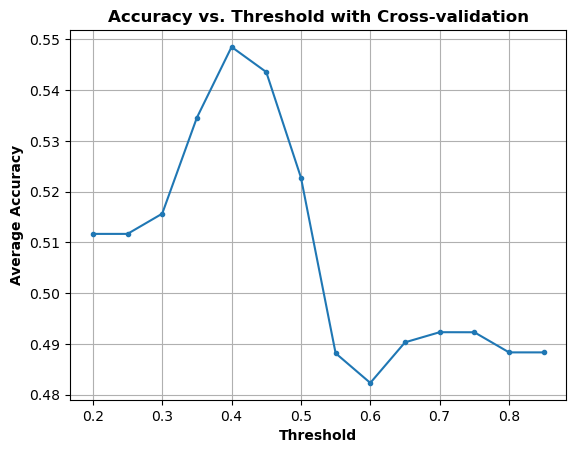

In [49]:
##################################################################
# Function to calculate accuracy for a given threshold and data split.
# Running logistic growth just once could result in different accuracy scores,
# This will run logistic gorwth with cross validation so we can run it multiple
# times an change the threshold as we choose
##################################################################
def log_growth_with_cv(threshold, n_splits=5):
    include_volume = False
    include_sector = False
    df = drop_columns(include_volume, include_sector, 'stock_data.csv')
    y = df['prediction-label']
    X = df.drop(columns=['prediction-label'])
    
    # Initialize cross-validation
    kf = KFold(n_splits=5)
    
    accuracy_scores = []  # List to store accuracy scores for each fold
    
    for train_index, test_index in kf.split(X):
        # Split the data based on the current fold
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        model = LogisticRegression(max_iter=2000)
        model.fit(X_train, y_train)
        
        # Get the probability predictions
        probability_predictions = model.predict_proba(X_test)
        prob_class_1 = probability_predictions[:, 1]
        
        # Apply the threshold
        class_label_predictions = (prob_class_1 >= threshold).astype(int)
        
        # Compute accuracy for this fold
        acc_score = accuracy_score(y_test, class_label_predictions)
        accuracy_scores.append(acc_score)
    
    # Return the average accuracy across all folds
    return np.mean(accuracy_scores)
    
##################################################################
# Wrapper function to test multiple thresholds and plot results
# This takes a few seconds to produce a plot
##################################################################
def test_thresholds_with_cv_and_plot():
    accuracy_scores = []
    thresholds = [x / 20.0 for x in range(4, 18)]  # [0.2, 0.3, ..., 0.8]
    
    # Evaluate accuracy for each threshold
    for threshold in thresholds:
        accuracy = log_growth_with_cv(threshold)
        accuracy_scores.append(accuracy)
    
    plt.plot(thresholds, accuracy_scores, marker='.')
    plt.title('Accuracy vs. Threshold with Cross-validation', fontweight='bold')
    plt.xlabel('Threshold', fontweight='bold')
    plt.ylabel('Average Accuracy', fontweight='bold')
    plt.grid(True)
    plt.show()

# Example usage (pass your DataFrame to the function)
test_thresholds_with_cv_and_plot()
